In [124]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from lime.lime_tabular import LimeTabularExplainer
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from lime.lime_tabular import LimeTabularExplainer
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import roc_curve, auc

pd.set_option('display.max_columns', None)

In [7]:
#load data with headers

df = pd.read_csv('/Users/tarabaris/Insight_Data_Science/project/perm_visa_all_years_C_D_limes.csv')

# Order features (numeric first, categorical second) since it's convenient later
feature_order = ['salary',
                 'state',
                 'job_title',
                 'level',
                 'education',
                 'citizenship',
                 'admission',
                 'ownership',
                 'language',
                 'outcome']


data = df[feature_order]



In [3]:
# Class to help select categorical vs. continuous data as part of the pipeline (see below)
class DataSelector(BaseEstimator, TransformerMixin):
    '''Select columns of numpy arrays based on attribute_indices.'''

    def __init__(self, attribute_indices):
        self.attribute_indices = attribute_indices

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array(X)[:,self.attribute_indices]

In [8]:
data.head()

,salary,state,job_title,level,education,citizenship,admission,ownership,language,outcome
0,83366.0,WI,Industrial_Engineers,Level IV,Bachelor's,INDIA,H-1B,N,N,0.0
1,16973.0,MS,Meat_Poultry_and_Fish_Cutters_and_Trimmers,Level I,None,SOUTH KOREA,NaN,N,N,1.0
2,49982.0,CO,Biological_Scientists_All_Other,Level I,Doctorate,GERMANY,H-1B,N,N,1.0
3,43514.0,WA,Market_Research_Analysts_and_Marketing_Special...,Level I,Master's,SOUTH KOREA,E-2,N,N,0.0
4,16973.0,MS,Meat_Poultry_and_Fish_Cutters_and_Trimmers,Level I,None,SOUTH KOREA,NaN,N,N,1.0


In [9]:
data.shape

(230233, 10)

In [10]:
data.dtypes

salary         float64
state           object
job_title       object
level           object
education       object
citizenship     object
admission       object
ownership       object
language        object
outcome        float64
dtype: object

In [11]:
#We want to replace any infinity values with "nan" so that we can drop them along with any other "nan" in order to run 
#throught our model
data.replace([np.inf, -np.inf], np.nan)

,salary,state,job_title,level,education,citizenship,admission,ownership,language,outcome
0,83366.0,WI,Industrial_Engineers,Level IV,Bachelor's,INDIA,H-1B,N,N,0.0
1,16973.0,MS,Meat_Poultry_and_Fish_Cutters_and_Trimmers,Level I,None,SOUTH KOREA,NaN,N,N,1.0
2,49982.0,CO,Biological_Scientists_All_Other,Level I,Doctorate,GERMANY,H-1B,N,N,1.0
3,43514.0,WA,Market_Research_Analysts_and_Marketing_Special...,Level I,Master's,SOUTH KOREA,E-2,N,N,0.0
4,16973.0,MS,Meat_Poultry_and_Fish_Cutters_and_Trimmers,Level I,None,SOUTH KOREA,NaN,N,N,1.0
5,24710.0,MI,Cooks_Restaurant,Level IV,None,SOUTH KOREA,F-1,N,N,0.0
6,55682.0,NY,Public_Relations_Specialists,Level II,Bachelor's,CANADA,H-1B,N,N,0.0
7,16973.0,MS,Meat_Poultry_and_Fish_Cutters_and_Trimmers,Level I,None,SOUTH KOREA,NaN,N,N,1.0
8,16973.0,MS,Meat_Poultry_and_Fish_Cutters_and_Trimmers,Level I,None,SOUTH KOREA,NaN,N,N,1.0
9,16973.0,MS,Meat_Poultry_and_Fish_Cutters_and_Trimmers,Level I,None,SOUTH KOREA,NaN,N,N,1.0


In [12]:
#Here we drop 'nan', which in this case also includes the converte infiinity values
data = data.dropna()

In [13]:
data.columns

Index([u'salary', u'state', u'job_title', u'level', u'education',
       u'citizenship', u'admission', u'ownership', u'language', u'outcome'],
      dtype='object')

In [14]:
# Define categorical names and indices
categorical_features = list(data.columns[1:])
categorical_idx = list(range(1, len(data.columns)-1))
continuous_features = list(data.columns[0:1])
continuous_idx = list(range(0,1))

Y = data.outcome.values
X = data.drop("outcome", axis=1).values

# Get feature names and their values for categorical data (needed for LIME)
categorical_names = {}
for idx, feature in zip(categorical_idx, categorical_features):
    le = LabelEncoder()
    X[:, idx] = le.fit_transform(X[:, idx])
    categorical_names[idx] = le.classes_

# To suppress a warning later (not strictly necessary)
X = X.astype(float)

# Train test split
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, train_size=0.70, random_state=42
)

/Users/tarabaris/anaconda/envs/my_projects_env/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [72]:
#In order to undersample, I separate out the data by the class, 1 is "True"/"Denied", and 0 is "False"/"Certified"
X_true = x_train[y_train == 1]
X_false = x_train[y_train == 0]

In [73]:
X_true.shape

(6608, 9)

In [74]:
X_false.shape

(133680, 9)

In [72]:
#I specify that I want the True class size to match the False class size when I oversample

In [75]:
X_false_sample = X_false[np.random.choice(len(X_false), size=6608, replace=False)]

In [76]:
X_false_sample.shape

(6608, 9)

In [77]:
X_true.shape

(6608, 9)

In [78]:
#Split the majority set into 20 groups
kf = KFold(n_splits=20)

In [79]:
split_data = [X_false[split[1]] for split in kf.split(X_false)]

In [83]:
for split in kf.split(X_false):
    print(X_false[split[1]].shape)

(6684, 9)
(6684, 9)
(6684, 9)
(6684, 9)
(6684, 9)
(6684, 9)
(6684, 9)
(6684, 9)
(6684, 9)
(6684, 9)
(6684, 9)
(6684, 9)
(6684, 9)
(6684, 9)
(6684, 9)
(6684, 9)
(6684, 9)
(6684, 9)
(6684, 9)
(6684, 9)


In [81]:
#Create the accompanying y values for the training sets
train_x_sets = [np.concatenate([split, X_true]) for split in split_data]
train_y_sets = [[0] * len(split) + [1]*len(X_true) for split in split_data]


In [82]:
# models = []
# predictions = []
# for xx, yy in zip(train_x_sets, train_y_sets):
#     model = RandomForestClassifier()
#     model.fit(xx, yy)
#     pred = model.predict(x_test)
#     models.append(model)
#     predictions.append(pred)




# Run grid search to tune hyperparameters

In [106]:
param_grid = {'n_estimators': [200, 500, 1000],
               'min_samples_split': [8, 12, 16, 20],
               'max_depth': [25, 50, 75, 150]}

#scoring=f1 to tune for better precision and recall

rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(xx, yy)



Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  7.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [200, 500, 1000], 'min_samples_split': [8, 12, 16, 20], 'max_depth': [25, 50, 75, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=1)

In [110]:
pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_min_samples_split,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
15,4.415908,0.165963,0.694561,0.890593,50,12,200,"{u'min_samples_split': 12, u'n_estimators': 20...",1,0.698084,0.891538,0.704354,0.891104,0.682718,0.891692,0.693785,0.889869,0.693862,0.888761,0.233003,0.009319,0.007067,0.001117
17,21.089066,0.929221,0.693942,0.892352,50,12,1000,"{u'min_samples_split': 12, u'n_estimators': 10...",2,0.695089,0.894129,0.700769,0.892624,0.684313,0.892682,0.693032,0.891675,0.696510,0.890652,0.166508,0.086053,0.005442,0.001157
37,11.556772,0.439900,0.693899,0.920415,150,8,500,"{u'min_samples_split': 8, u'n_estimators': 500...",3,0.697905,0.921277,0.701447,0.923283,0.682344,0.920680,0.688180,0.918395,0.699623,0.918438,0.193501,0.048327,0.007376,0.001846
39,4.188209,0.160574,0.693752,0.890960,150,12,200,"{u'min_samples_split': 12, u'n_estimators': 20...",4,0.696018,0.892378,0.702951,0.890381,0.679642,0.891235,0.691667,0.890340,0.698485,0.890465,0.195631,0.020484,0.007946,0.000781
14,23.045973,0.878270,0.693726,0.920941,50,8,1000,"{u'min_samples_split': 8, u'n_estimators': 100...",5,0.693009,0.921915,0.701141,0.923269,0.681361,0.921224,0.694674,0.918753,0.698449,0.919545,0.097924,0.032627,0.006806,0.001624
41,21.478017,0.868469,0.693599,0.892433,150,12,1000,"{u'min_samples_split': 12, u'n_estimators': 10...",6,0.696947,0.894399,0.698462,0.891791,0.685625,0.892819,0.692337,0.891125,0.694624,0.892031,0.125898,0.044304,0.004497,0.001122
28,10.687245,0.452287,0.693382,0.891686,75,12,500,"{u'min_samples_split': 12, u'n_estimators': 50...",7,0.694127,0.893226,0.700809,0.892166,0.685848,0.892452,0.691005,0.890017,0.695122,0.890568,0.107898,0.022386,0.004923,0.001202
16,10.982650,0.440209,0.693324,0.892077,50,12,500,"{u'min_samples_split': 12, u'n_estimators': 50...",8,0.697639,0.894244,0.702848,0.892751,0.679172,0.892933,0.691610,0.890634,0.695354,0.889824,0.179170,0.044461,0.007959,0.001615
25,10.993991,0.457164,0.693212,0.920001,75,8,500,"{u'min_samples_split': 8, u'n_estimators': 500...",9,0.698941,0.921557,0.702846,0.922399,0.680341,0.920172,0.687195,0.916995,0.696740,0.918883,0.328056,0.052335,0.008246,0.001923
13,12.035331,0.477261,0.692980,0.920289,50,8,500,"{u'min_samples_split': 8, u'n_estimators': 500...",10,0.690937,0.920750,0.705123,0.922134,0.681818,0.919973,0.688697,0.919531,0.698328,0.919059,0.182710,0.053293,0.008040,0.001077


In [109]:
#Create and ensemble of random forest models for each group frome the majority class having all the minority class in the set.
models = []
predictions = []
probabilities = []
for xx, yy in zip(train_x_sets, train_y_sets):
    model = RandomForestClassifier(n_estimators=200, max_depth = 50, min_samples_split = 12)
    model.fit(xx, yy)
    pred = model.predict(x_test)
    proba = model.predict_proba(x_test)
    models.append(model)
    predictions.append(pred)
    probabilities.append(proba)

predictions = np.array(predictions)
probabilities = np.array(probabilities)




# Get and plot model importances!

In [111]:
importances = model.feature_importances_
#std = np.std([tree.feature_importances_ for tree in best_estimator.estimators_],
#             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
feature_names = data.columns[:-1]
for f in range(data.shape[1]-1):
    print("%2d. feature %s (%f)" %
          (f + 1, feature_names[f], importances[indices[f]]))

Feature ranking:
 1. feature salary (0.380373)
 2. feature state (0.164257)
 3. feature job_title (0.141785)
 4. feature level (0.109003)
 5. feature education (0.072943)
 6. feature citizenship (0.069066)
 7. feature admission (0.048932)
 8. feature ownership (0.009355)
 9. feature language (0.004285)


In [112]:
ranking_df = pd.DataFrame([(feature_names[f], importances[indices[f]]) for f in range(data.shape[1]-1)])
ranking_df.columns = ["feature_name", "importance"]
ranking_df

,feature_name,importance
0,salary,0.380373
1,state,0.164257
2,job_title,0.141785
3,level,0.109003
4,education,0.072943
5,citizenship,0.069066
6,admission,0.048932
7,ownership,0.009355
8,language,0.004285


In [113]:
# ranking_df['feature_name'].replace('salary', 'Salary')
# ranking_df['feature_name'].replace('state', 'State')
# ranking_df['feature_name'].replace('job_title', 'Job title')
# ranking_df['feature_name'].replace('level', 'Pay level')
# ranking_df['feature_name'].replace('education', 'Education')
# ranking_df['feature_name'].replace('citizenship', 'Citizenship')
# ranking_df['feature_name'].replace('admission', 'Admission')
# ranking_df['feature_name'].replace('refile', 'Refile')
# ranking_df['feature_name'].replace('ownership', 'Ownership interest')
# ranking_df['feature_name'].replace('language', 'Language Requirement')

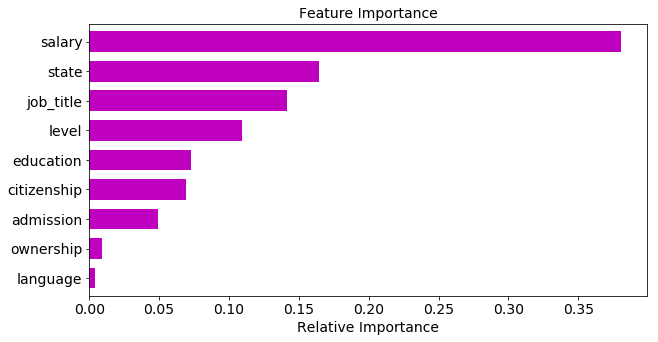

In [114]:
ranking_df.plot(kind="barh", color ='m', figsize=(10,5), fontsize=(14), width = .7, stacked=True, grid=False, legend=False)
plt.gca().set_yticklabels(ranking_df.feature_name)
plt.gca().invert_yaxis()
plt.title('Feature Importance', fontsize=(14))
plt.xlabel('Relative Importance', fontsize=(14))
plt.ylabel('', fontsize=(14))

# Define the model in order to use LIME and get precision, recall, accuracy

In [115]:
class RFEnsemble(object):
    
    def __init__(self, models):
        self.models = models
    
    def predict_proba(self, X):
        proba_all = np.array([md.predict_proba(X) for md in self.models])
        proba = proba_all.mean(axis=0)
        return proba

    def predict(self, X):
        proba = self.predict_proba(X)
        return proba[:, 1] >= 0.5
    
    
        

In [116]:
my_model = RFEnsemble(models)

In [117]:
my_predictions = my_model.predict(x_test)
my_pred_proba = my_model.predict_proba(x_test)


In [118]:
accuracy_score(y_test, my_predictions)
precision_score(y_test, my_predictions)
recall_score(y_test, my_predictions)


0.69354838709677424

In [93]:
print(classification_report(y_test, my_predictions))

             precision    recall  f1-score   support

        0.0       0.98      0.73      0.84     57210
        1.0       0.12      0.69      0.20      2914

avg / total       0.94      0.73      0.81     60124



In [94]:
my_model.predict(x_test)

array([False, False, False, ...,  True, False, False], dtype=bool)

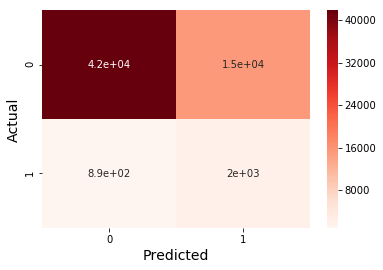

In [122]:
cm = confusion_matrix(y_test, my_predictions)
sns.heatmap(cm, annot=True, cmap="Reds")
plt.xlabel("Predicted", size=14)
plt.ylabel("Actual", size=14)

plt.show()

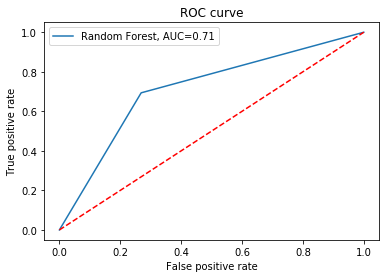

In [126]:
y_pred_rf = model.predict_proba(x_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, my_predictions)

roc_auc=auc(fpr_rf, tpr_rf)

plt.plot(fpr_rf, tpr_rf, label='Random Forest, AUC=%0.2f'% roc_auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.plot([0,1],[0,1],'r--')
#roc_auc=auc(fpr_rf, tpr_rf)
plt.show()

# Now we can use LIME to explain why an indiviual was either certified or denied

In [97]:
# Use LIME to explain individual predictions, initialize explainer object
explainer = LimeTabularExplainer(
    X_true[:, :-1],
    class_names=['Denied', 'Certified'],
    feature_names=list(data.columns[:-1]),
    categorical_features=categorical_idx,
    categorical_names=categorical_names,
    discretize_continuous=True
)

In [191]:
example

3

('Probability of receiving a visa:', 0.65000000000000002)


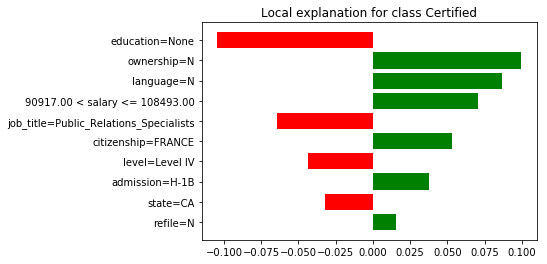

In [203]:
# Explain a prediction ("local interpretability"): 
# Now we see that the pipeline that takes raw data and returns the prediction 
# of the trained model now comes in conveniently.
example = 3
exp = explainer.explain_instance(test[:, :-1][example], my_model.predict_proba, num_features=10)


# exp = explainer.explain_instance(test[example], model.predict_proba, num_features=5)
print('Probability of receiving a visa:', exp.predict_proba[1])
exp.as_pyplot_figure()

('Probability of receiving a visa:', 0.78988095238095235)


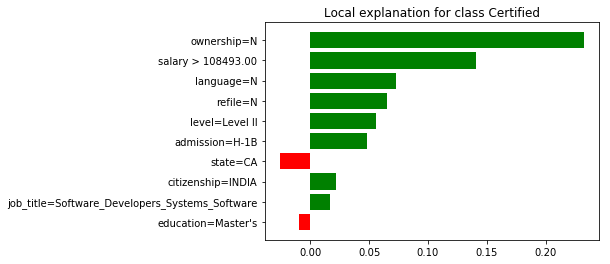

In [213]:
# Explain a prediction ("local interpretability"): 
# Now we see that the pipeline that takes raw data and returns the prediction 
# of the trained model now comes in conveniently.
example = 10
exp = explainer.explain_instance(test[:, :-1][example], my_model.predict_proba, num_features=10)


# exp = explainer.explain_instance(test[example], model.predict_proba, num_features=5)
print('Probability of receiving a visa:', exp.predict_proba[1])
exp.as_pyplot_figure()

('Probability of receiving a visa:', 0.5)


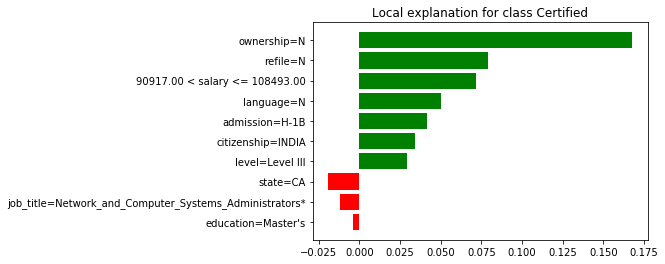

In [219]:
# Explain a prediction ("local interpretability"): 
# Now we see that the pipeline that takes raw data and returns the prediction 
# of the trained model now comes in conveniently.
example = 608
exp = explainer.explain_instance(test[:, :-1][example], my_model.predict_proba, num_features=10)


# exp = explainer.explain_instance(test[example], model.predict_proba, num_features=5)
print('Probability of receiving a visa:', exp.predict_proba[1])
exp.as_pyplot_figure()

In [193]:
np.array(current).shape

(10,)

('Couples probability of staying together:', 0.37614967235285984)


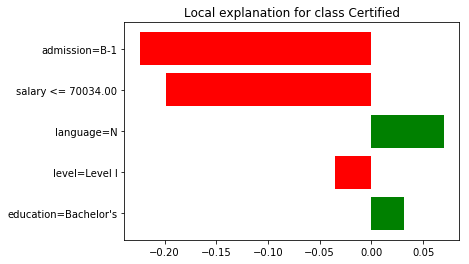

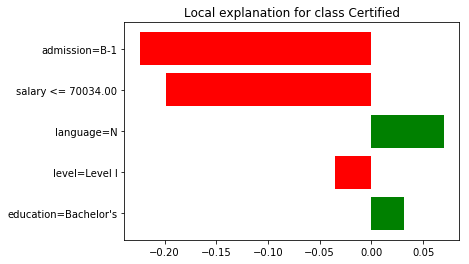

In [299]:
# Using LIME for for relationship management (not advised): Current chance of relationship success.
current = [34, 36, 2, 0, 1, 0, 1, 0, 0, 0]
exp = explainer.explain_instance(np.array(current), my_model.predict_proba, num_features=5)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()